# 6.逻辑回归
在训练的初始阶段，我们将要构建一个逻辑回归模型来预测，某个学生是否被大学录取。
设想你是大学相关部分的管理者，想通过申请学生两次测试的评分，来决定他们是否被录取。
现在你拥有之前申请学生的可以用于训练逻辑回归的训练样本集。对于每一个训练样本，你有他们两次测试的评分和最后是被录取的结果。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('6.1.txt',header=None,names=['Exam1','Exam2','Admitted'])
data.head()

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


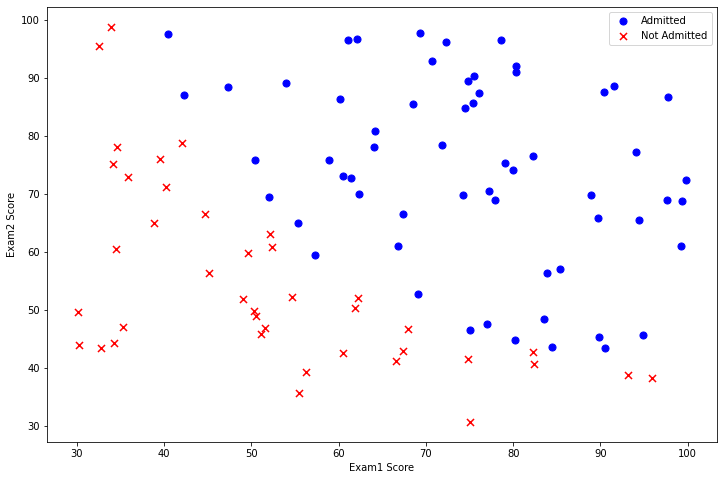

In [3]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam1'], positive['Exam2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam1'], negative['Exam2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
plt.show()

In [4]:
#sigmoid 函数
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [5]:
#实现代价函数
def cost(theta,X,y):
    theta=np.matrix(theta)
    X=np.matrix(X)
    y=np.matrix(y)
    first=np.multiply(-y,np.log(sigmoid(X*theta.T)))
    second=np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    return np.sum(first-second)/(len(X))

In [6]:
#初始化X，y，θ

# 加一列常数列
data.insert(0, 'Ones', 1)

# 初始化X，y，θ
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
theta = np.zeros(3)

# 转换X，y的类型
X = np.array(X.values) #array:产生数组
y = np.array(y.values) #values:返回值

In [7]:
# 检查矩阵的维度
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

In [8]:
# 用初始θ计算代价
cost(theta, X, y)

0.6931471805599453

In [9]:
# 实现梯度计算的函数（并没有更新θ）
def gradient(theta, X, y):
    theta = np.matrix(theta) #数组化
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1]) #ravel：将多维数组转换为一维数组，参数theta的数量
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

In [10]:
import scipy.optimize as opt
result=opt.fmin_tnc(func=cost,x0=theta,fprime=gradient,args=(X,y))
#调用一个已有的库，不用自己定义迭代次数和步长，功能会直接告诉我们最优解
#参数: func:优化的目标函数，x0:初值，fprime:提供优化函数func的梯度函数，否则优化函数func必须返回函数值和梯度，或者设置approx_grad=True
#approx_grad :如果设置为True，会给出近似梯度，args：元组，是传递给优化函数的参数
#返回：x：θ,nfeval：整数，function evaluations的数目,在一次迭代过程中会有多次function evaluation
result

(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

In [11]:
# 用θ的计算结果代回代价函数计算
cost(result[0], X, y)

0.20349770158947458

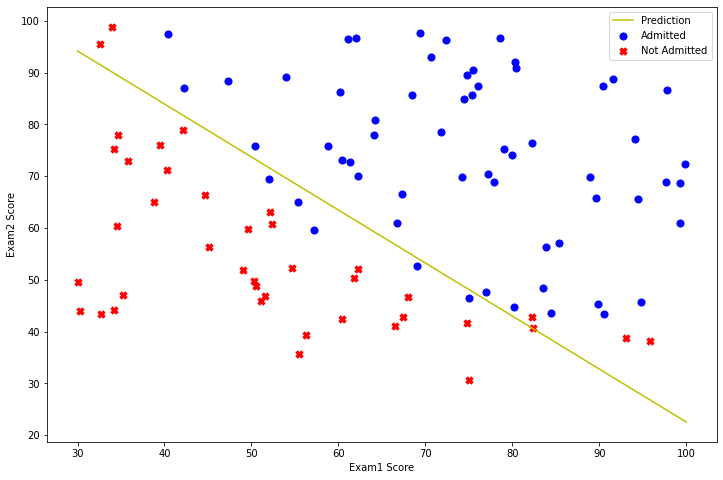

In [12]:
#画出决策曲线
plotting_x1=np.linspace(30,100,100) #等差数列，表示在区间[30, 100]之间取100个点作为横坐标   X
plotting_h1=(-result[0][0]-result[0][1]*plotting_x1)/result[0][2] #θt*X=0为决策边界(x0=1)  y
#result[0]是theta3个值的一个数组，result[0][0]表示从theta的三个值中取第一个值
fig,ax=plt.subplots(figsize=(12,8)) #创建绘图空间
ax.plot(plotting_x1,plotting_h1,'y',label='Prediction') #画线
ax.scatter(positive['Exam1'], positive['Exam2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam1'], negative['Exam2'], s=50, c='r', marker='X', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
plt.show()

In [13]:
# 实现hθ
def hfunc1(theta, X):
    return sigmoid(np.dot(theta.T, X))
hfunc1(result[0],[1,45,85])

0.7762906240463825

In [14]:
# 定义预测函数
def predict(theta, X):
    probability = sigmoid(X * theta.T) #dot是乘法，*是点乘
    return [1 if x >= 0.5 else 0 for x in probability]

In [15]:
# 统计预测正确率
theta_min = np.matrix(result[0]) #取θ数组
predictions = predict(theta_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)] #zip：压缩，保留一一对应的关系
accuracy = (sum(map(int, correct)) % len(correct)) #map()会根据提供的函数对指定的顺序做映射。
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%


# 7.正则化逻辑回归
在训练的第二部分，我们将实现加入正则项提升逻辑回归算法。
设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果，测试结果决定是否芯片要被接受或抛弃。
你有一些历史数据，帮助你构建一个逻辑回归模型。

In [16]:
data_init = pd.read_csv('6.2.txt', header=None, names=['Test 1', 'Test 2', 'Accepted'])
data_init.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


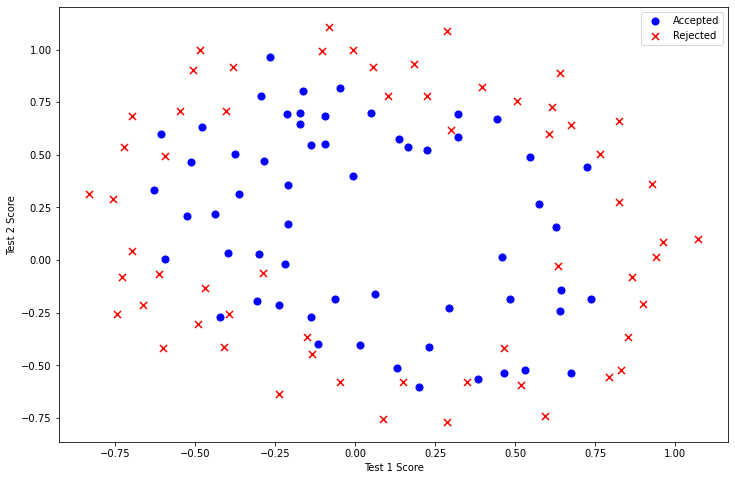

In [17]:
positive2 = data_init[data_init['Accepted'].isin([1])]
negative2 = data_init[data_init['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

#### 特征映射
一种更好的使用数据集的方式是为每组数据创造更多的特征。所以我们为每组 x_1,x_2 添加了最高到6次幂的特征

In [18]:
degree = 6
data2 = data_init
x1 = data2['Test 1']
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree+1):
    for j in range(0, i+1):
        data2['F' + str(i-j) + str(j)] = np.power(x1, i-j) * np.power(x2, j) #power：求幂

data2.drop('Test 1', axis=1, inplace=True) #drop:删除指定行列
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F01,F20,F11,F02,F30,F21,F12,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


#### 代价函数和梯度

In [19]:
# 实现正则化的代价函数
def costReg(theta, X, y, learningRate): #learningRate：正则化参数
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) #正则化项，不取θ0
    #数组切片：逗号“,”分隔各个维度，“:”表示各个维度内的切片，只有:表示取这个维度的全部值
    #X[:2,1:] 第一维取下标2之前的，即第2行之前（0，1两行），列上从第一列开始取，不要第0列
    return np.sum(first - second) / len(X) + reg

In [20]:
# 实现正则化的梯度函数
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1]) #shape[1]:theta的列数，即参数θ的数量
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X) #θ0不正则化
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i]) #正则化梯度下降
    
    return grad

In [21]:
# 初始化X，y，θ
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]
theta2 = np.zeros(cols-1)

# 进行类型转换
X2 = np.array(X2.values)
y2 = np.array(y2.values)

# λ设为1
learningRate = 1

In [22]:
# 计算初始代价
costReg(theta2, X2, y2, learningRate)

0.6931471805599454

In [23]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([ 1.27271027,  0.62529965,  1.18111686, -2.01987399, -0.9174319 ,
        -1.43166929,  0.12393227, -0.36553118, -0.35725403, -0.17516292,
        -1.45817009, -0.05098418, -0.61558552, -0.27469165, -1.19271298,
        -0.24217841, -0.20603297, -0.04466178, -0.27778952, -0.29539513,
        -0.45645981, -1.04319155,  0.02779373, -0.29244872,  0.01555761,
        -0.32742406, -0.1438915 , -0.92467487]),
 32,
 1)

In [24]:
#预测函数查看在训练数据上的准确度
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 98%


In [25]:
#画出决策的曲线
def hfunc2(theta, x1, x2):
    temp = theta[0][0]
    place = 0
    for i in range(1, degree+1):
        for j in range(0, i+1):
            temp+= np.power(x1, i-j) * np.power(x2, j)* theta[0][place+1]  #假设函数
            place+=1
    return temp

In [26]:
#找决策边界
def find_decision_boundary(theta):
    t1 = np.linspace(-1, 1.5, 1000) #在指定的间隔内返回均匀间隔的数字 1000为样本数
    t2 = np.linspace(-1, 1.5, 1000)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates) #zip(*):将原来的行的列表转换为列的列表; zip():将两个不同序列的元素以元组形式一一配对
    h_val = pd.DataFrame({'x1':x_cord, 'x2':y_cord}) #DataFrame是由多种类型的列构成的二维标签数据结构
    h_val['hval'] = hfunc2(theta, h_val['x1'], h_val['x2']) #代入假设函数

    decision = h_val[np.abs(h_val['hval'])< 2 * 10**-3 ] #abs()：函数返回数字的绝对值；** ：乘方 ；2 * 10**-1：边界宽度（描点）
    return decision.x1, decision.x2


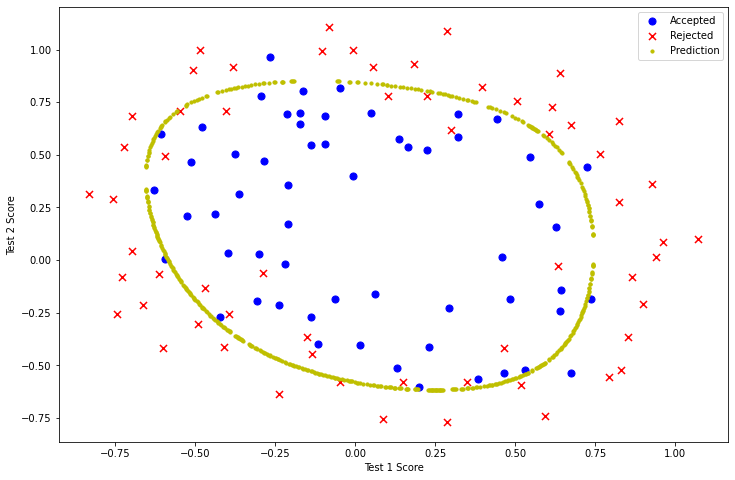

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result2) #把θ代入
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()

In [28]:
#改变λ，观察决策曲线
#过拟合
learningRate2 = 0
result3 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate2))
result3

(array([ 9.11192364e+00,  1.18840465e+01,  6.30828094e+00, -8.39706468e+01,
        -4.48639810e+01, -3.81221435e+01, -9.42525756e+01, -8.14257602e+01,
        -4.22413355e+01, -3.52968361e+00,  2.95734207e+02,  2.51308760e+02,
         3.64155830e+02,  1.61036970e+02,  5.70100234e+01,  1.71716716e+02,
         2.72109672e+02,  3.12447535e+02,  1.41764016e+02,  3.22495698e+01,
        -1.75836912e-01, -3.58663811e+02, -4.82161916e+02, -7.49974915e+02,
        -5.03764307e+02, -4.80978435e+02, -1.85566236e+02, -3.83936243e+01]),
 280,
 3)

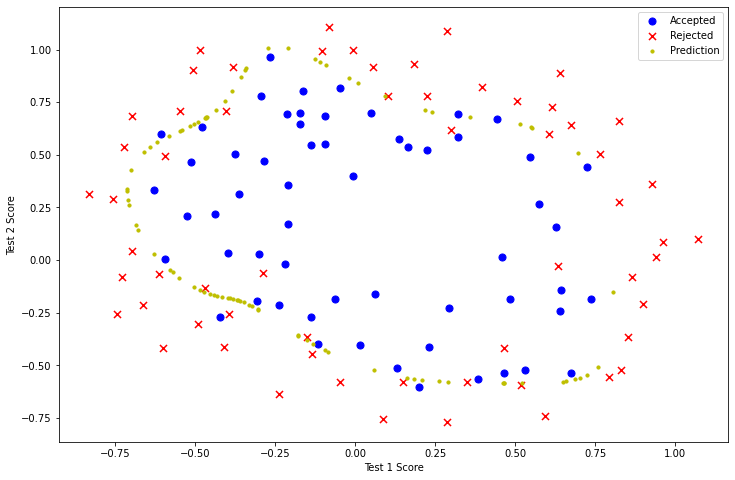

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result3)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()

In [30]:
#欠拟合
learningRate3 = 100
result4 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate3))

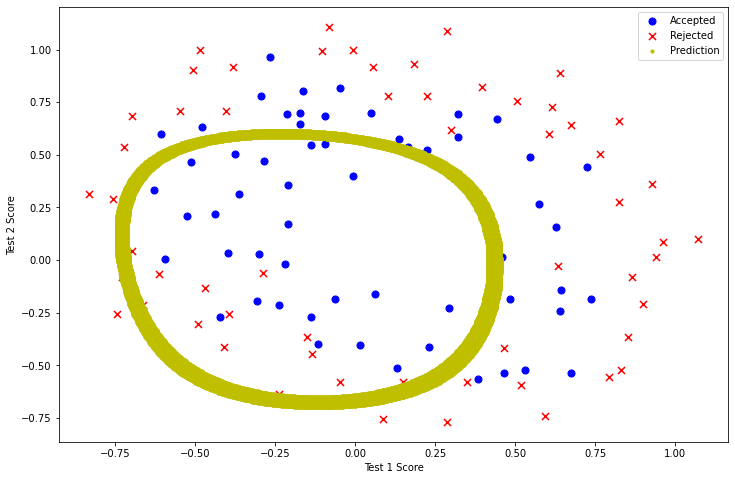

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result4)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()